# Data understanding II and cleaning
**Part 2**

The purpose of this project is to predict the price of housing in different block groups accross California based on a set of input attributes within the dataset. Each row represents the data of an observed block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from sklearn.linear_model import LinearRegression

In [2]:
housing = pd.read_csv('data/housing.csv')

  ## Exploring the relationships between variables

In [3]:
housing.corr().style.background_gradient()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


In [4]:
corr_columns = ['housing_median_age', 'total_rooms','total_bedrooms', 
                'population', 'households','median_income','median_house_value', 'ocean_proximity']
corr_df = housing[corr_columns].dropna(axis=0)
corr_df['ocean_proximity'] = corr_df['ocean_proximity'].replace({'INLAND':0,'<1H OCEAN':1,'NEAR OCEAN':2,'NEAR BAY':3,'ISLAND':4})

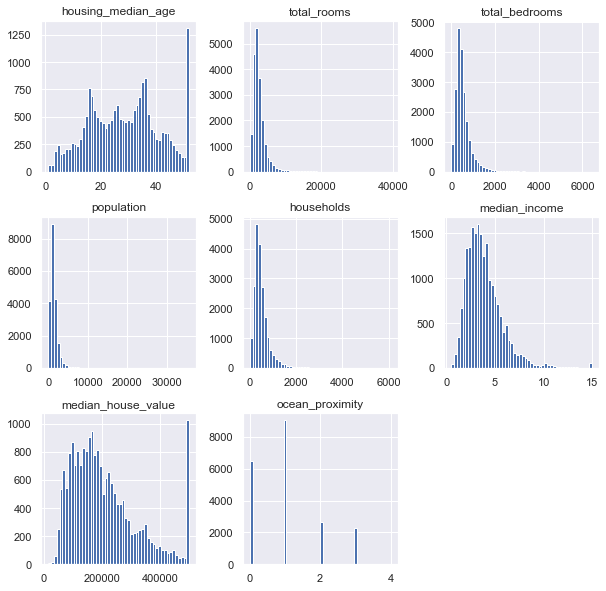

In [5]:
corr_df.hist(bins=50, figsize=(10, 10))
plt.show()

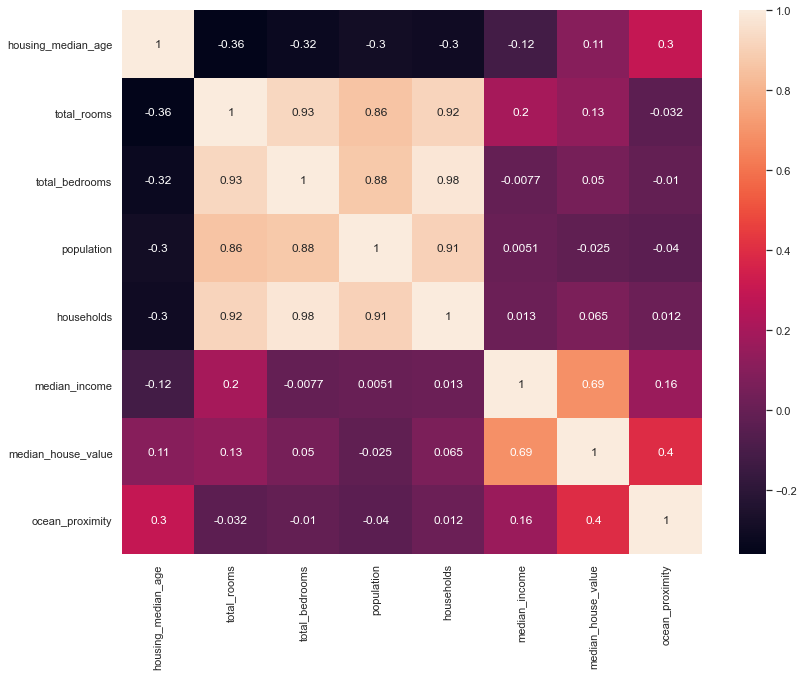

In [6]:
corr = corr_df.corr()
plt.figure(figsize=(13, 10))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)
plt.show()

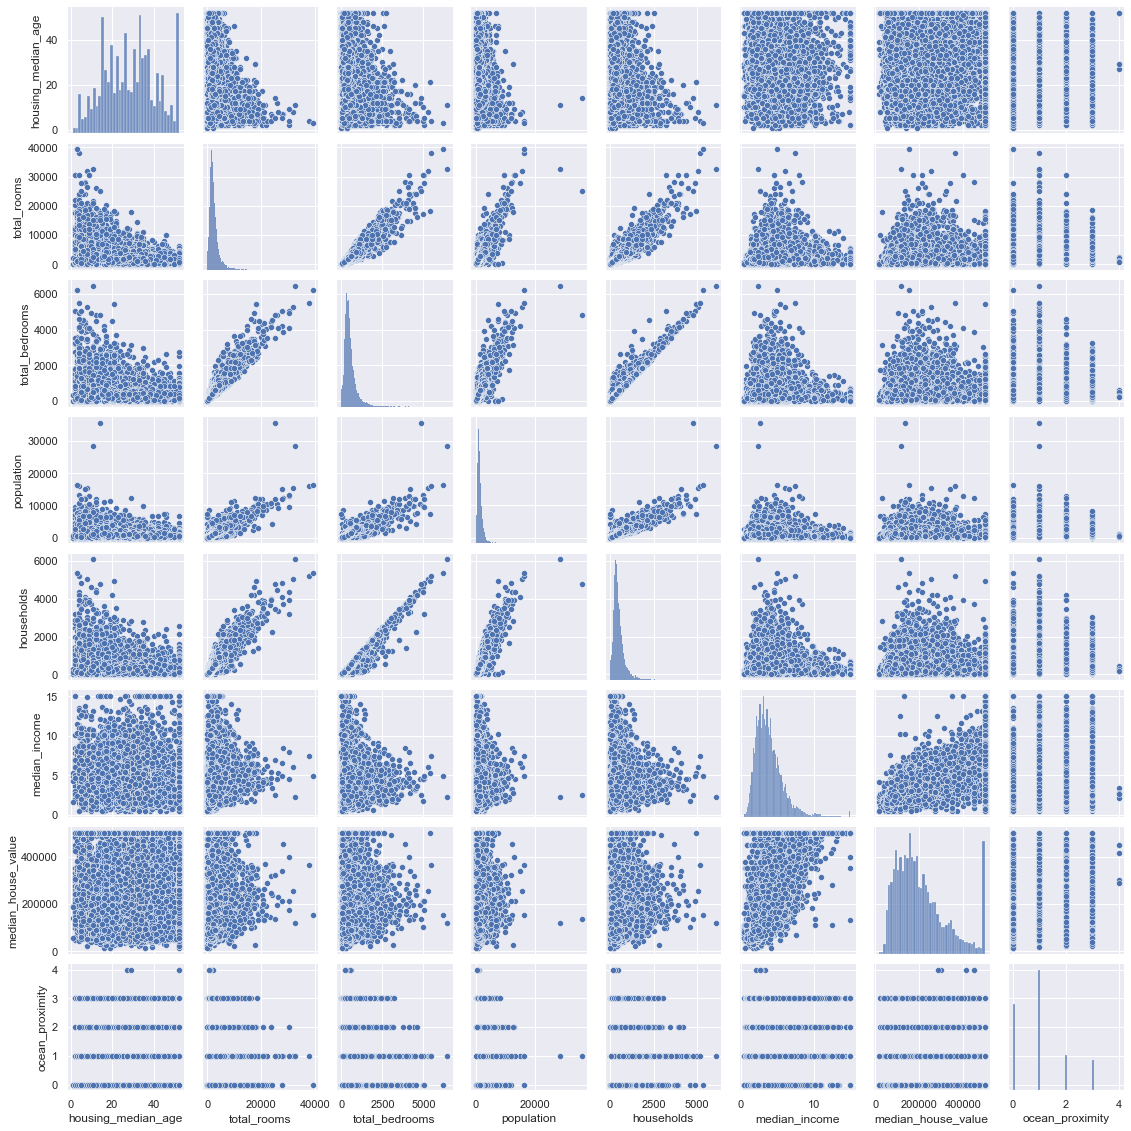

In [7]:
sns.pairplot(corr_df, height = 2, dropna=True)
plt.show()

## Filling in missing values with basic linear regression

                            OLS Regression Results                            
Dep. Variable:         total_bedrooms   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                 2.000e+05
Date:                Tue, 27 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:06:15   Log-Likelihood:            -1.1761e+05
No. Observations:               20433   AIC:                         2.352e+05
Df Residuals:                   20429   BIC:                         2.353e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.7599      0.885      0.859      

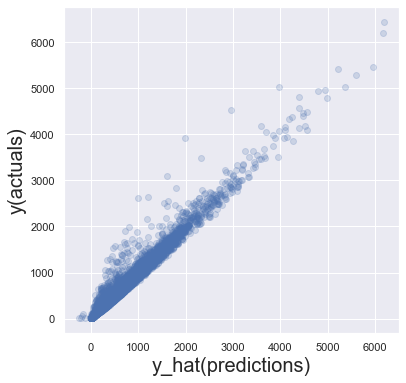

In [49]:
x1 = housing[housing['total_bedrooms'].notna()][['total_rooms','population','households']]
y = housing[housing['total_bedrooms'].notna()]['total_bedrooms']
x = sm.add_constant(x1)
model1 = sm.OLS(y,x).fit()
print(model1.summary())

plt.rcParams['figure.figsize']=(6, 6) 
y_hat = model1.predict(x)
plt.scatter(y_hat, y, alpha=0.2)
plt.xlabel('y_hat(predictions)', fontsize = 20)
plt.ylabel('y(actuals)', fontsize = 20)
plt.show()

                            OLS Regression Results                            
Dep. Variable:         total_bedrooms   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                 4.887e+05
Date:                Tue, 27 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:08:54   Log-Likelihood:            -1.1963e+05
No. Observations:               20433   AIC:                         2.393e+05
Df Residuals:                   20431   BIC:                         2.393e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4649      0.972     -1.508      0.1

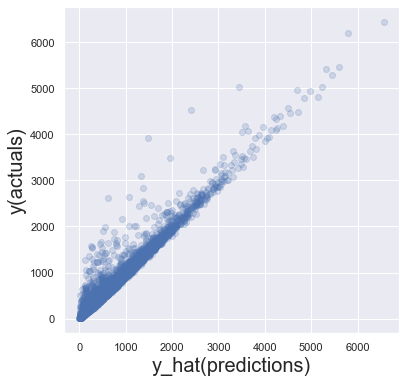

In [53]:
x1 = housing[housing['total_bedrooms'].notna()][['households']]
y = housing[housing['total_bedrooms'].notna()]['total_bedrooms']
x = sm.add_constant(x1)
model2 = sm.OLS(y,x).fit()
print(model2.summary())

plt.rcParams['figure.figsize']=(6, 6) 
y_hat2 = model2.predict(x)
plt.scatter(y_hat2, y, alpha=0.2)
plt.xlabel('y_hat(predictions)', fontsize = 20)
plt.ylabel('y(actuals)', fontsize = 20)
plt.show()

model 1 has the higher r-squared value and lower F-statistic value

In [57]:
housing_filled = housing.copy()

missing_totalbedrooms = housing[housing['total_bedrooms'].isna()]
missing_totalbedrooms_x1 = missing_totalbedrooms[['households']]
missing_totalbedrooms_x = sm.add_constant(missing_totalbedrooms_x1)
missing_totalbedrooms_y_hat = model2.predict(missing_totalbedrooms_x)

housing_filled.loc[housing_filled['total_bedrooms'].isna(), 'total_bedrooms'] = missing_totalbedrooms_y_hat

In [58]:
housing_filled.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

## Fixing outliers - housing_median_age, median_income, median_house_value

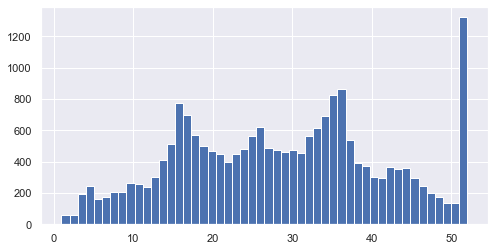

In [59]:
plt.rcParams['figure.figsize']=(8, 4)
housing_filled['housing_median_age'].hist(bins=50)
plt.show()

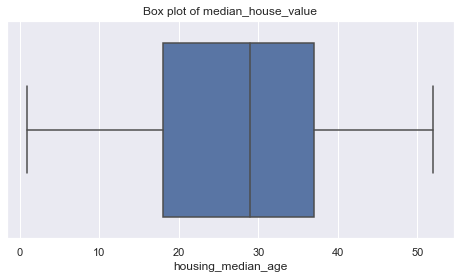

In [60]:
sns.boxplot(x=housing_filled['housing_median_age']).set_title('Box plot of median_house_value')
plt.show()

In [61]:
housing_max = housing_filled['housing_median_age'].max()
print(f'The Maximum housing age: {housing_max}')

housing_95 = housing_filled['housing_median_age'].quantile(.95)
print(f'The 95th percentile housing age: {housing_95}')

number = housing_filled[housing_filled['housing_median_age']==housing_max].shape[0]
print(f'Number of observations at max {number}')
print('Percent of observations at max %.3f' % (number/housing.shape[0]*100)+'%')

number = housing_filled[housing_filled['housing_median_age']>=housing_95].shape[0]
print(f'Number of observations greather than 95th percentile {number}')
print('Percent of observations greater 95th percentile %.3f' % (number/housing.shape[0]*100)+'%')

The Maximum housing age: 52.0
The 95th percentile housing age: 52.0
Number of observations at max 1273
Percent of observations at max 6.168%
Number of observations greather than 95th percentile 1273
Percent of observations greater 95th percentile 6.168%


### I will not remove anything since the outliers account for a high percentage of rows and this feature will not be used in modelling due to its low correlation with median income

## Median income 

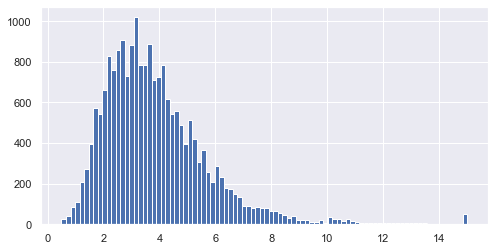

In [62]:
housing_filled['median_income'].hist(bins=90)
plt.show()

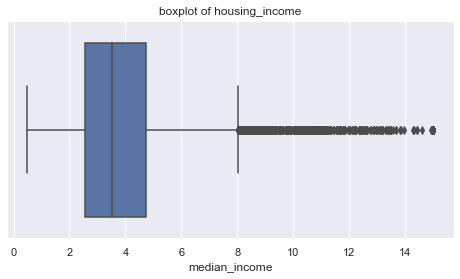

In [63]:
sns.boxplot(x=housing_filled['median_income']).set_title('boxplot of housing_income')
plt.show()

In [64]:
income_max = housing_filled['median_income'].max()
print(f'The Maximum housing income: {income_max}')

income_95 = housing_filled['median_income'].quantile(.95)
print(f'The 95th percentile housing income: {income_95}')

number = housing_filled[housing_filled['median_income']==income_max].shape[0]
print(f'Number of observations at max: {number}')
print('Percent of observations at max: %.3f' % (number/housing.shape[0]*100)+'%')

number = housing_filled[housing_filled['median_income']>=income_95].shape[0]
print(f'Number of observations greater than 95th percentile {number}')
print('Percent of observations greater than 95th percentile %.3f' % (number/housing.shape[0]*100)+'%')

The Maximum housing income: 15.0001
The 95th percentile housing income: 7.300305
Number of observations at max: 49
Percent of observations at max: 0.237%
Number of observations greater than 95th percentile 1032
Percent of observations greater than 95th percentile 5.000%


### An unusual number of high income
The data seems to be noise after income rises over 10

In [65]:
number = housing_filled[housing_filled['median_income']>10].shape[0]
print(f'Number of observations greater than 10 {number}')
print('Percent of observations greater than 10 %.3f' % (number/housing.shape[0]*100)+'%')

Number of observations greater than 10 308
Percent of observations greater than 10 1.492%


In [66]:
housing_outrem = housing_filled.copy()
housing_outrem = housing_outrem[housing_outrem['median_income'] <= 10]
housing_outrem.shape

(20332, 10)

## Median house value

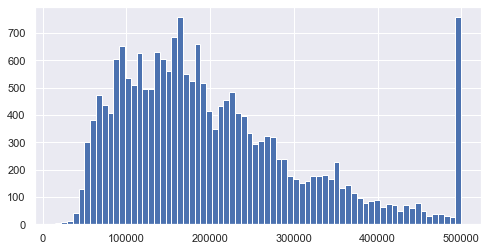

In [67]:
housing_outrem['median_house_value'].hist(bins=70)
plt.show()

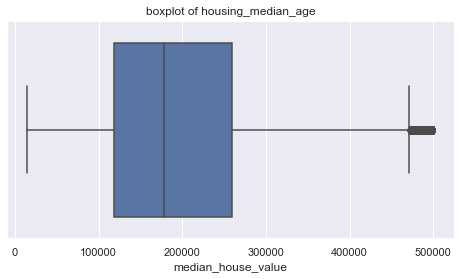

In [68]:
sns.boxplot(x=housing_outrem['median_house_value']).set_title('boxplot of housing_median_age')
plt.show()

In [69]:
value_max = housing_outrem['median_house_value'].max()
print(f'The Maximum housing age= {value_max}')

value_95 = housing_outrem['median_house_value'].quantile(.95)
print(f'The 95th percentile housing age = {value_95}')

number = housing_outrem[housing_outrem['median_house_value']==value_max].shape[0]
print(f'Number of observations = max {number}')
print('Percent of observations = max %.3f' % (number/housing.shape[0]*100)+'%')

number = housing_outrem[housing_outrem['median_house_value']>=value_95].shape[0]
print(f'Number of observations >= 95th percentile {number}')
print('Percent of observations >= 95th percentile %.3f' % (number/housing.shape[0]*100)+'%')

The Maximum housing age= 500001.0
The 95th percentile housing age = 448190.0000000002
Number of observations = max 706
Percent of observations = max 3.421%
Number of observations >= 95th percentile 1017
Percent of observations >= 95th percentile 4.927%


<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

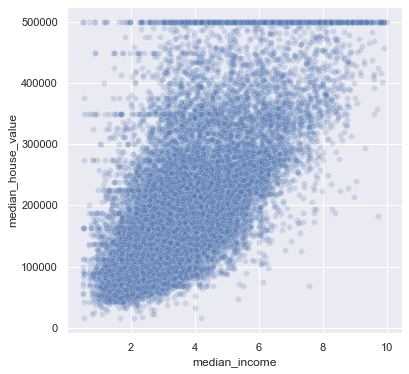

In [70]:
# This is our only correlated variable
plt.figure(figsize=(6,6))
sns.scatterplot(x=housing_outrem['median_income'], y=housing_outrem['median_house_value'], alpha=0.2)

### An unusual number of houses at the max value (3.421%)
Possibly a neighbourhood of similar luxury housing block estates managed by the same real estate developer. We will treat this as an outliet and take this out of the dataset 

### This upper echelon of data could be modelled with a multi-level model which out of the scope

In [71]:
housing_outrem = housing_outrem[housing_outrem['median_house_value'] < value_max]
housing_outrem.shape

(19626, 10)

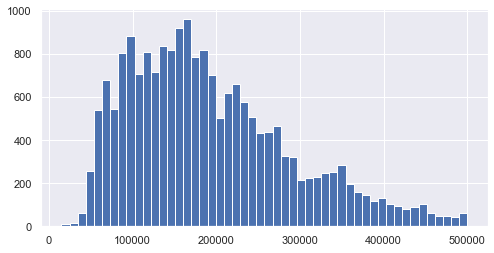

In [72]:
housing_outrem['median_house_value'].hist(bins=50)
plt.show()

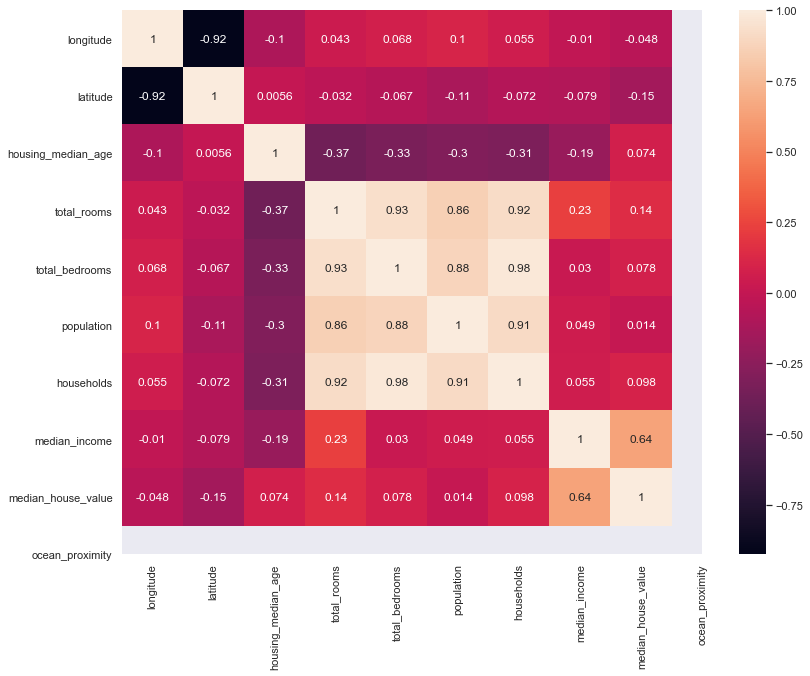

In [73]:
plt.figure(figsize=(13,10))
sns.heatmap(housing_outrem.corr(), xticklabels=housing_outrem.columns, yticklabels=housing_outrem.columns, annot=True)
plt.show()

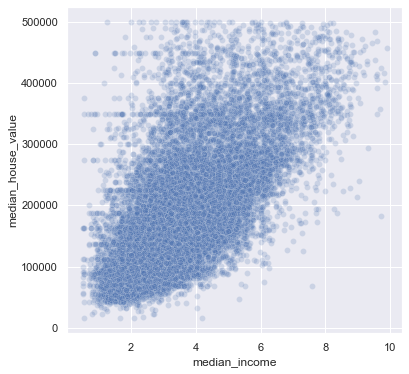

In [74]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=housing_outrem['median_income'], y=housing_outrem['median_house_value'], alpha=0.2)
plt.show()

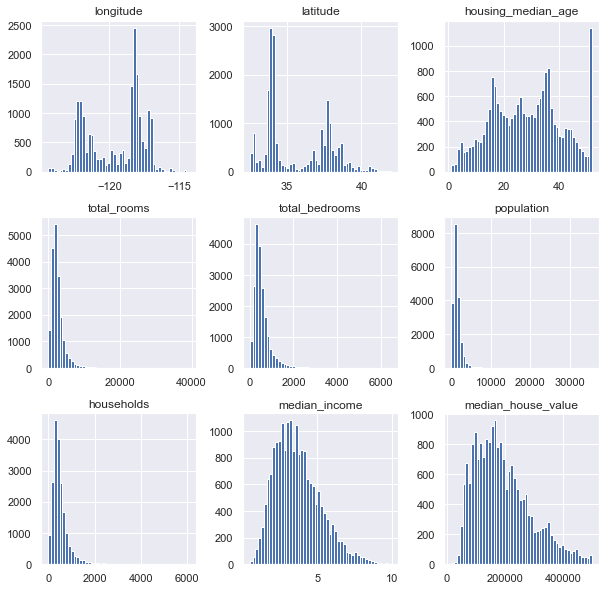

In [75]:
housing_outrem.hist(bins=50, figsize=(10,10))
plt.show()

In [76]:
housing_outrem.shape

(19626, 10)

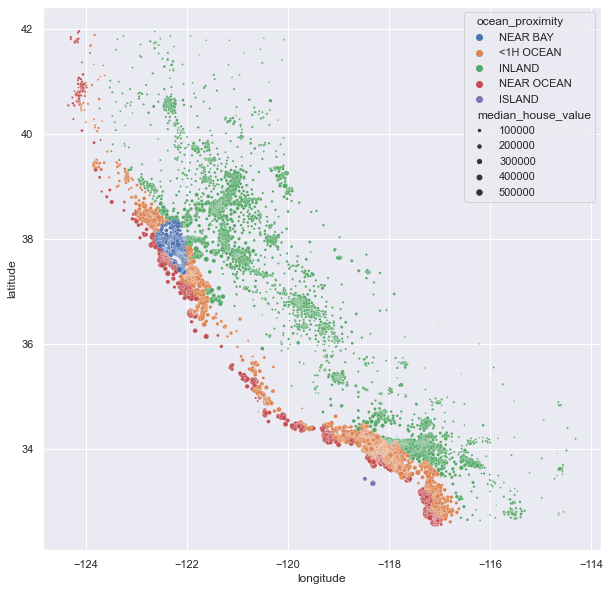

In [77]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=housing_outrem, x='longitude', y='latitude', hue='ocean_proximity', size='median_house_value', sizes=(1,30))
plt.show()

In [78]:
housing_outrem.to_csv('data/housing_cleaned.csv', index=False)

## Checking if the removed data is correlated with ocean_proximity

In [79]:
plt.rcParams['figure.figsize']=(10, 10) 

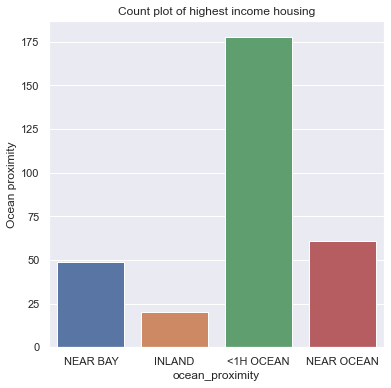

In [80]:
plt.figure(figsize=(6,6))
top_housing = housing[housing['median_income']>10]
cp = sns.countplot(x='ocean_proximity', data=top_housing)
cp.set_title('Count plot of highest income housing')
cp.set_ylabel('Ocean proximity')
plt.show()

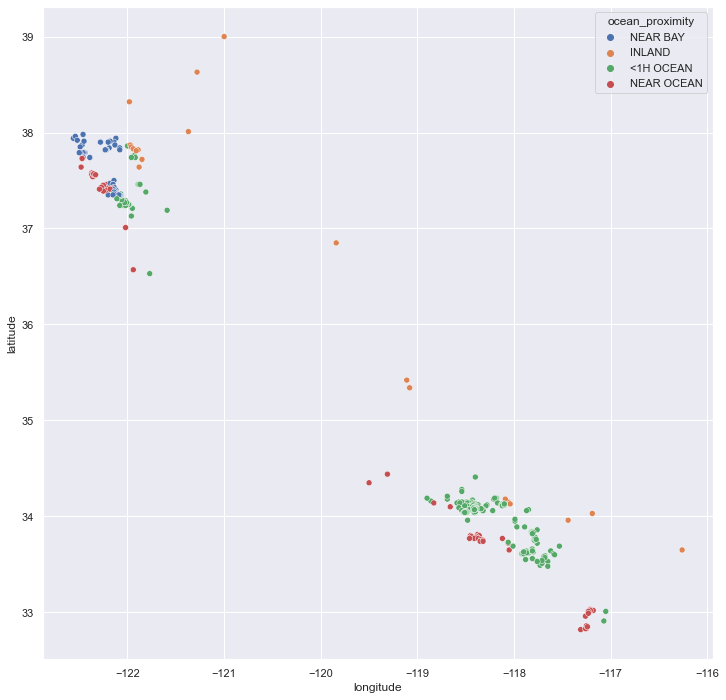

In [81]:
plt.rcParams['figure.figsize']=(12, 12) 
sns.scatterplot(data=top_housing, x='longitude', y='latitude', hue='ocean_proximity', legend='full')
plt.show()

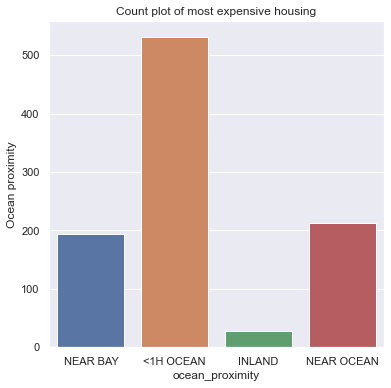

In [82]:
plt.figure(figsize=(6,6))
top_housing = housing[housing['median_house_value']>=value_max]
cp = sns.countplot(x='ocean_proximity', data=top_housing)
cp.set_title('Count plot of most expensive housing')
cp.set_ylabel('Ocean proximity')
plt.show()

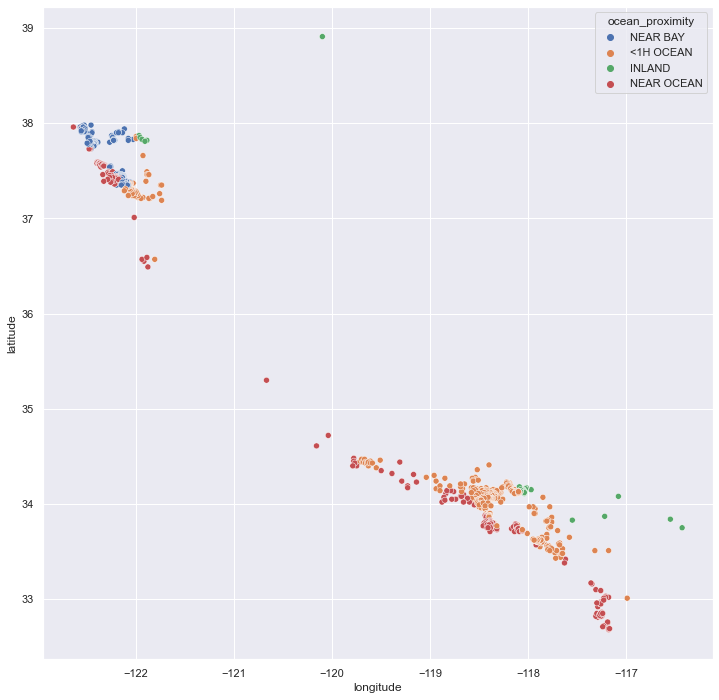

In [83]:
sns.scatterplot(data=top_housing, x='longitude', y='latitude', hue='ocean_proximity', legend='full')
plt.show()